# Cluster Lens Simulation Interface

This notebook shows the current progress in the group and cluster scale simulations.

Implemented:
* NFWCluster deflector class: a NFW halo and EPL subhalos
* Integration with Lens interface to simulate lens related quanities.
* Use cluster catalog to build a cluster lens population
* Generate a cluster lens population with LensPop

Not yet implemented:
* Realistic halo population based on halo mass distribution instead of catalogs
* Larger scatter for the halo and source center

## Setup

In [1]:
from slsim.Deflectors.deflector import Deflector
from slsim.lens import Lens
from slsim.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
from slsim.image_simulation import simulate_image, rgb_image_from_image_list
from slsim import lsst_science_pipeline

from astropy.cosmology import FlatLambdaCDM

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u

Generate a population of sources and cluster deflectors usin the redMaPPer cluster catalog

In [2]:
np.random.seed(0)

In [3]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = u.Quantity(value=0.1, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 26, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 26, "z_min": 0.1, "z_max": 5.0}

cluster_config = {
        "cluster_catalog": "../data/redMaPPer/clusters_example.fits",
        "members_catalog": "../data/redMaPPer/members_example.fits"
    }

# run skypy pipeline and make galaxy-galaxy population class using LensPop
cluster_lens_pop = LensPop(
    deflector_type="cluster-catalog",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=None,
    cluster_config=cluster_config,
    sky_area=sky_area,
    cosmo=cosmo,
)

## Generate images of random lenses

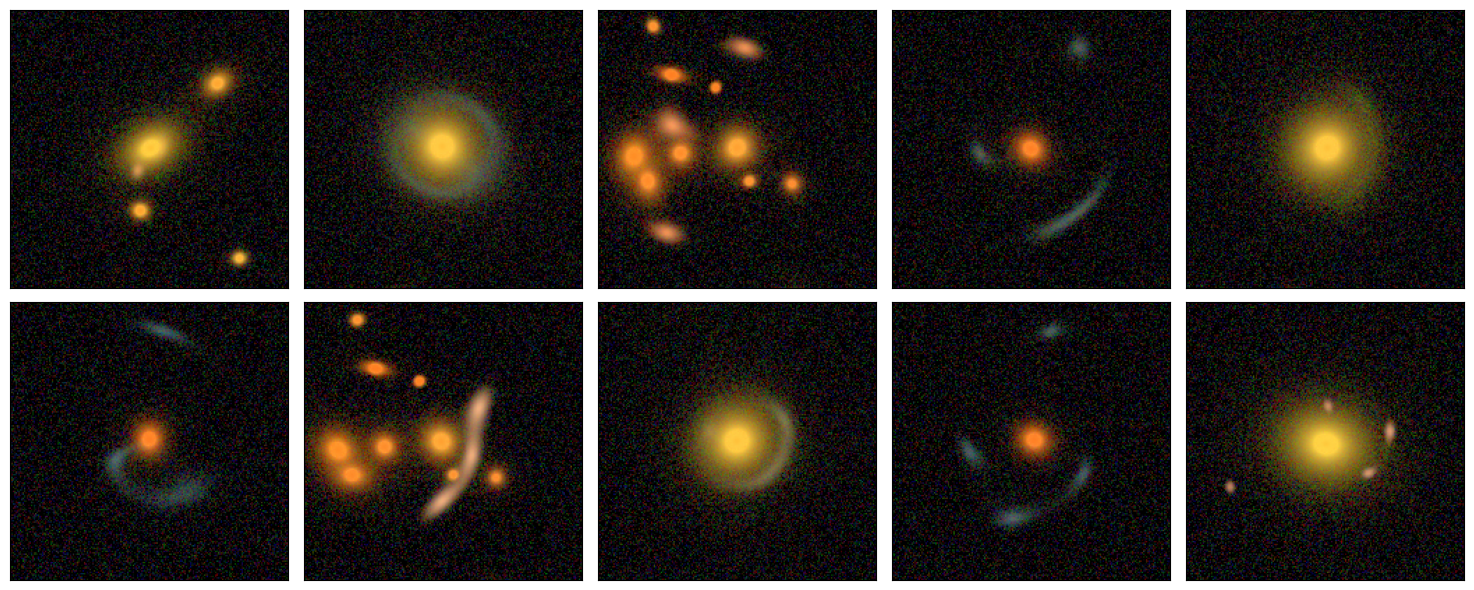

In [4]:
# make some cuts in the image separations and limited magnitudes of the arc
kwargs_lens_cut_plot = {
    "min_image_separation": 2.0,
    "max_image_separation": 30.0,
    "mag_arc_limit": {"g": 23, "r": 23, "i": 23},
}


cluster_lens_plot = LensingPlots(cluster_lens_pop, num_pix=200, coadd_years=10)

# generate montage indicating which bands are used for the rgb color image
fig, axes = cluster_lens_plot.plot_montage(
    rgb_band_list=["i", "r", "g"],
    add_noise=True,
    n_horizont=5,
    n_vertical=2,
    kwargs_lens_cut=kwargs_lens_cut_plot,
)
plt.show()